# Goals
* Predict Results of Pro matches with 70% accuracy

### Data that will be used
* match data and maps

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


data = pd.read_csv('scrapy/vlrgg/playerData/vlr.csv')

# Creating the baseline model
Using logistic regression to predict wins (for the first iteration)

Inputs for this model will include:
* 5 Players on team
* 5 Players on opponent team
* Agents each player is on
* Map

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

csv_data = pd.read_csv('refined.csv')
used_columns = csv_data.columns.tolist()
used_columns.remove('date')
used_columns.remove('result')
used_columns.remove('Unnamed: 0')

X_data = pd.get_dummies(csv_data[used_columns]).to_numpy()
y_data = pd.get_dummies(csv_data['result'])['Win'].to_numpy()


X_train, X_test, y_train, y_test = train_test_split(X_data,y_data,test_size=0.25,random_state=69)

clf = LogisticRegression(penalty="none")
clf.fit(X_train, y_train)



LogisticRegression(penalty='none')

In [3]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = clf.predict(X_test)
print(confusion_matrix(y_pred=y_pred, y_true=y_test))
print(accuracy_score(y_pred=y_pred, y_true=y_test))

[[ 812  643]
 [ 526 1475]]
0.6617476851851852


Initial model gives a subpar baseline of 65-70% accuracy, but this purely uses categorical data. More data could be considered such as
* Player's kda moving average from the past 5 games (if information is available)
* disregard the player names
* Twitter sentiment before the game starts (graph this correlation first)

This will introduce more numerical data in here, which can be graphed, making it easier to see correlations.
Also using a moving average to adjust for the fact that the game is constantly being updated and metas are changing.

# Another iteration of Logistic Regression
This time more numbers will be used rather than just purely using categorical data

newData contains the 5 game moving average for numerical data, such as kda, first blood, first death, and headshot percentage.

In [4]:
newData = pd.read_csv('movingAverage.csv').dropna()
newData

,Unnamed: 0,playerName,playerTeam,map,playerAgent,playerKills,playerDeaths,playerAssists,playerACS,playerADR,...,playerFirstBlood,playerFirstDeath,matchID,opponent,result,winnerRoundsWon,loserRoundsWon,winningTeam,date,event
15,113970,0PZ,ORB,Ascent,phoenix,11.7,16.8,3.3,179.9,117.6,...,2.6,3.3,CREAvsORB17-07-21,CREA,Lose,13,7,CREA,2021-07-17,Champions Tour Japan Stage 3: Challengers 2
40,33711,0uate,AE,Icebox,sova,10.0,13.4,6.7,163.4,113.8,...,1.1,1.7,TIvsAE25-02-21,TI,Lose,13,1,TI,2021-02-25,Champions Tour North America Stage 1: Challeng...
41,33857,0uate,AE,Bind,sova,11.0,13.5,7.1,177.2,120.8,...,1.1,1.6,TIvsAE25-02-21,TI,Lose,13,8,TI,2021-02-25,Champions Tour North America Stage 1: Challeng...
42,34767,0uate,AE,Bind,sova,11.6,13.5,7.2,183.0,123.8,...,0.9,1.5,AEvsWIND25-02-21,WIND,Lose,13,6,WIND,2021-02-25,Champions Tour North America Stage 1: Challeng...
43,58270,0uate,AE,Icebox,killjoy,11.6,14.6,6.7,179.4,117.1,...,1.0,1.6,V1vsAE01-04-21,V1,Lose,13,9,V1,2021-04-01,Champions Tour North America Stage 2: Challeng...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140314,115857,게노리,FOOD,Ascent,raze,13.9,15.3,3.7,215.2,133.6,...,3.1,2.0,FOODvsAUTO16-04-21,AUTO,Lose,13,7,AUTO,2021-04-16,Champions Tour Korea Stage 2: Challengers
140341,134401,여 누,TAIL,Haven,killjoy,11.2,15.0,5.9,176.6,115.7,...,1.7,1.8,MANvsTAIL03-07-21,MAN,Win,13,9,TAIL,2021-07-03,Champions Tour Korea Stage 3: Challengers
140342,134415,여 누,TAIL,Ascent,killjoy,11.9,14.6,5.5,178.3,113.0,...,1.9,2.0,MANvsTAIL03-07-21,MAN,Win,13,7,TAIL,2021-07-03,Champions Tour Korea Stage 3: Challengers
140343,134554,여 누,TAIL,Ascent,breach,11.4,14.4,5.2,171.8,108.2,...,2.0,2.1,GMGvsTAIL03-07-21,GMG,Lose,13,2,GMG,2021-07-03,Champions Tour Korea Stage 3: Challengers


#### Visualization of data

Graph of team average kill death ratio and win rate

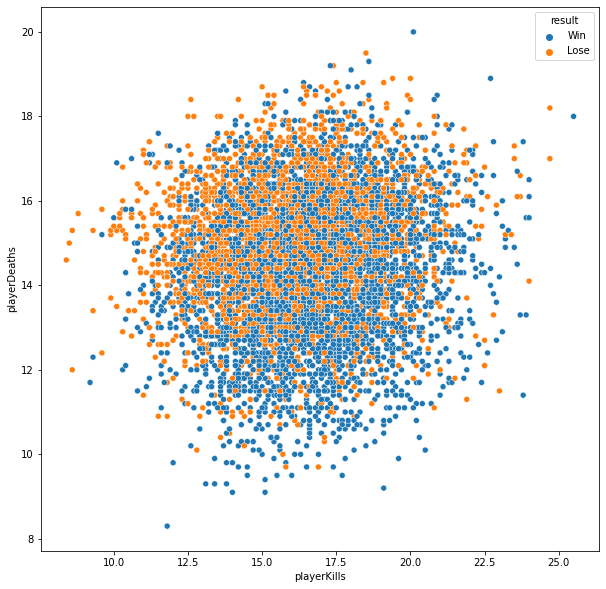

In [5]:
plt.figure(figsize=(10,10))
plot = sns.scatterplot(data=newData[newData['playerAgent']=='raze'], x="playerKills", y='playerDeaths', hue="result")


It does seem like players with higher kda's win more often, but this metric has quite a bit of noise in it. This makes sense since controller and sentinel agents can have high impact in a match without getting kills. Additionally, rather than just having individual performance, we will sum the team performance for each map.

Regardless, the graph does signal that this is a promising metric to use for the next model.

In [6]:
used_cols = ['playerTeam', 'matchID', 'map', 'playerKills', 'playerDeaths', 'playerAssists', 'playerACS', 'playerADR', 'playerHS', 'playerFirstBlood', 'playerFirstDeath', 'result']
num_cols = ['playerKills', 'playerDeaths', 'playerAssists', 'playerACS', 'playerADR', 'playerHS', 'playerFirstBlood', 'playerFirstDeath']
teamAVG = pd.DataFrame()
teamAVG = newData.copy()
teamAVG[num_cols] = teamAVG.groupby(['matchID', 'map', 'playerTeam', 'result'])[num_cols].transform('sum')
teamAVG = teamAVG.drop(['playerName', 'Unnamed: 0', 'playerAgent'], 1).drop_duplicates()
#dataframe has summation of individual player 5 game rolling averages



<AxesSubplot:xlabel='playerKills', ylabel='playerDeaths'>

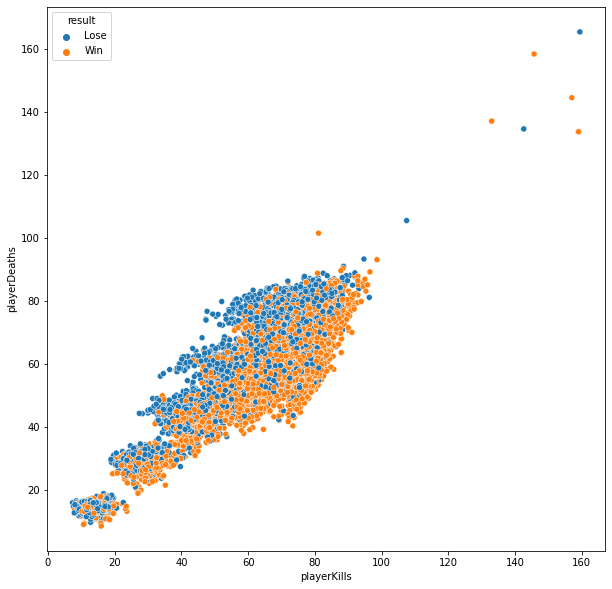

In [7]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=teamAVG, x='playerKills', y='playerDeaths', hue='result')
#graph of team 5 game rolling average kills and deaths

### Adding team data into the new model
Unsurprisingly how well the team does as a whole has more impact on a game than any individual player can (even if they are a duelist)

This signals that our model should still take into account every players performance within the team and could possibly use total team k/d ratio as a parameter.

In [8]:
#getting the data ready for model
num_cols = ['playerKills', 'playerDeaths', 'playerAssists', 'playerACS', 'playerADR', 'playerHS']
cat_cols = ['map', 'playerTeam', 'opponent', 'result']
modelDF = pd.DataFrame()
modelDF = pd.get_dummies(teamAVG[cat_cols])
modelDF[num_cols] = teamAVG[num_cols]
X_train, X_test, y_train, y_test = train_test_split(modelDF.drop(['result_Lose', 'result_Win'], 1), modelDF['result_Win'])


In [10]:
clf = LogisticRegression(random_state= 24, max_iter=10000)
clf.fit(X_train, y_train)
print(confusion_matrix(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))

[[1313  740]
 [ 571 2070]]
0.7207072858968896
